# Doing Bayesian Data Analysis

Simple example from __Chapter 16__.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

from utils import plt, sns

In [2]:
df = pd.read_csv("data/TwoGroupIQ.csv")
# Only work with the "Smart Drug" group
df = df[df.Group == "Smart Drug"]

print len(df)
df.head()

63


,Score,Group
0,102,Smart Drug
1,107,Smart Drug
2,92,Smart Drug
3,101,Smart Drug
4,110,Smart Drug


In [3]:
with pm.Model() as model:
    # Priors
    sigma = pm.Uniform("sigma", df.Score.std() / 1000, df.Score.std() * 1000)
    mu = pm.Normal("mu", mu=0, tau=1E-8)
    # Likelihood
    y = pm.Normal("y", mu=mu, sd=sigma, observed=df.Score)
    # Sample
    trace = pm.sample(draws=5000, tune=1000, chain=3)
    
burn_in = 1000
trace = trace[burn_in:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -367.99: 100%|██████████| 200000/200000 [00:11<00:00, 17141.78it/s]
Finished [100%]: Average ELBO = -362.56
100%|██████████| 5000/5000 [00:04<00:00, 1183.18it/s]


             mean        sd  mc_error     hpd_2.5    hpd_97.5
mu     107.715808  3.242048  0.054275  101.222703  114.226800
sigma   26.047421  2.417653  0.074271   21.573169   30.871761


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116539d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1165ac610>]], dtype=object)

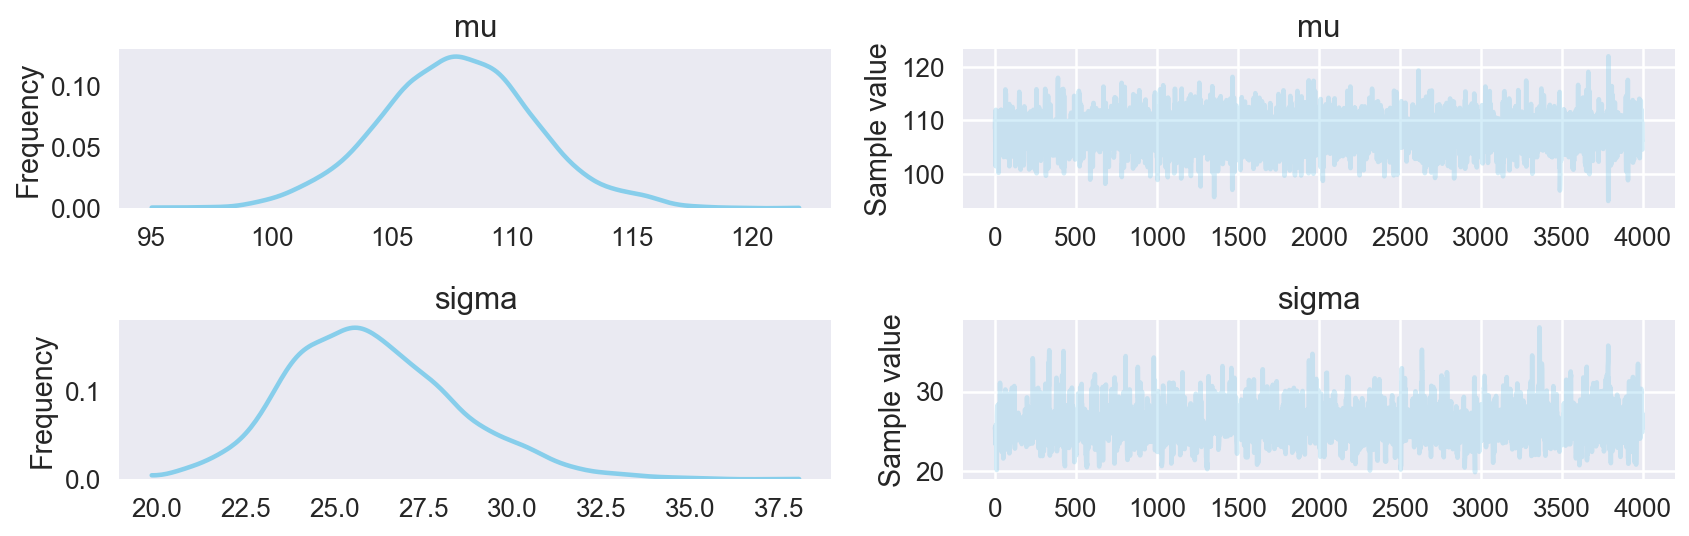

In [4]:
print pm.df_summary(trace)
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1165e9e10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1187c3550>], dtype=object)

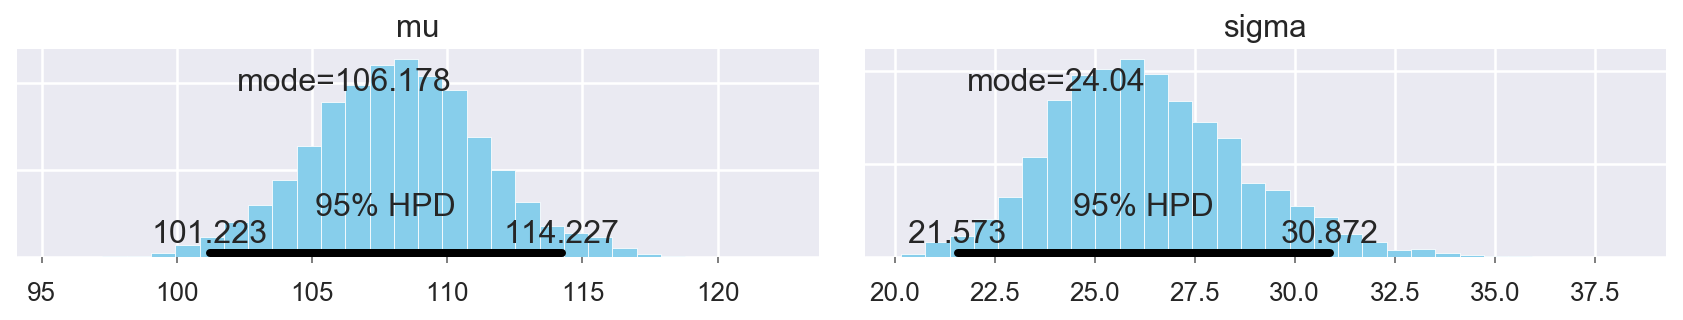

In [5]:
pm.plot_posterior(trace, point_estimate="mode")

### Robust Estimation

Use the `StudentT` distribution for likelihood.

In [6]:
with pm.Model() as robust_model:
    # Priors
    sigma = pm.HalfCauchy("sigma", 25)
    mu = pm.Normal("mu", mu=0, tau=1E-8)
    nu = pm.Gamma("nu", 2, .1)  # Taken from `Stan` docs
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=mu, sd=sigma, observed=df.Score)
    effect_size = (mu - 100) / sigma
    normality = tt.log10(nu)
    # Sample
    trace = pm.sample(draws=5000, tune=1000, chain=3)
    
burn_in = 1000
trace = trace[burn_in:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -360.41: 100%|██████████| 200000/200000 [00:18<00:00, 11042.87it/s]
Finished [100%]: Average ELBO = -354.39
100%|██████████| 5000/5000 [00:10<00:00, 484.86it/s]


             mean        sd  mc_error     hpd_2.5    hpd_97.5
mu     107.165332  2.852844  0.041451  101.726864  113.047412
sigma   20.123552  3.266701  0.121736   13.854880   26.356189
nu       9.485864  8.534082  0.249009    1.238491   26.323667


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117a23ad0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117b53e90>]], dtype=object)

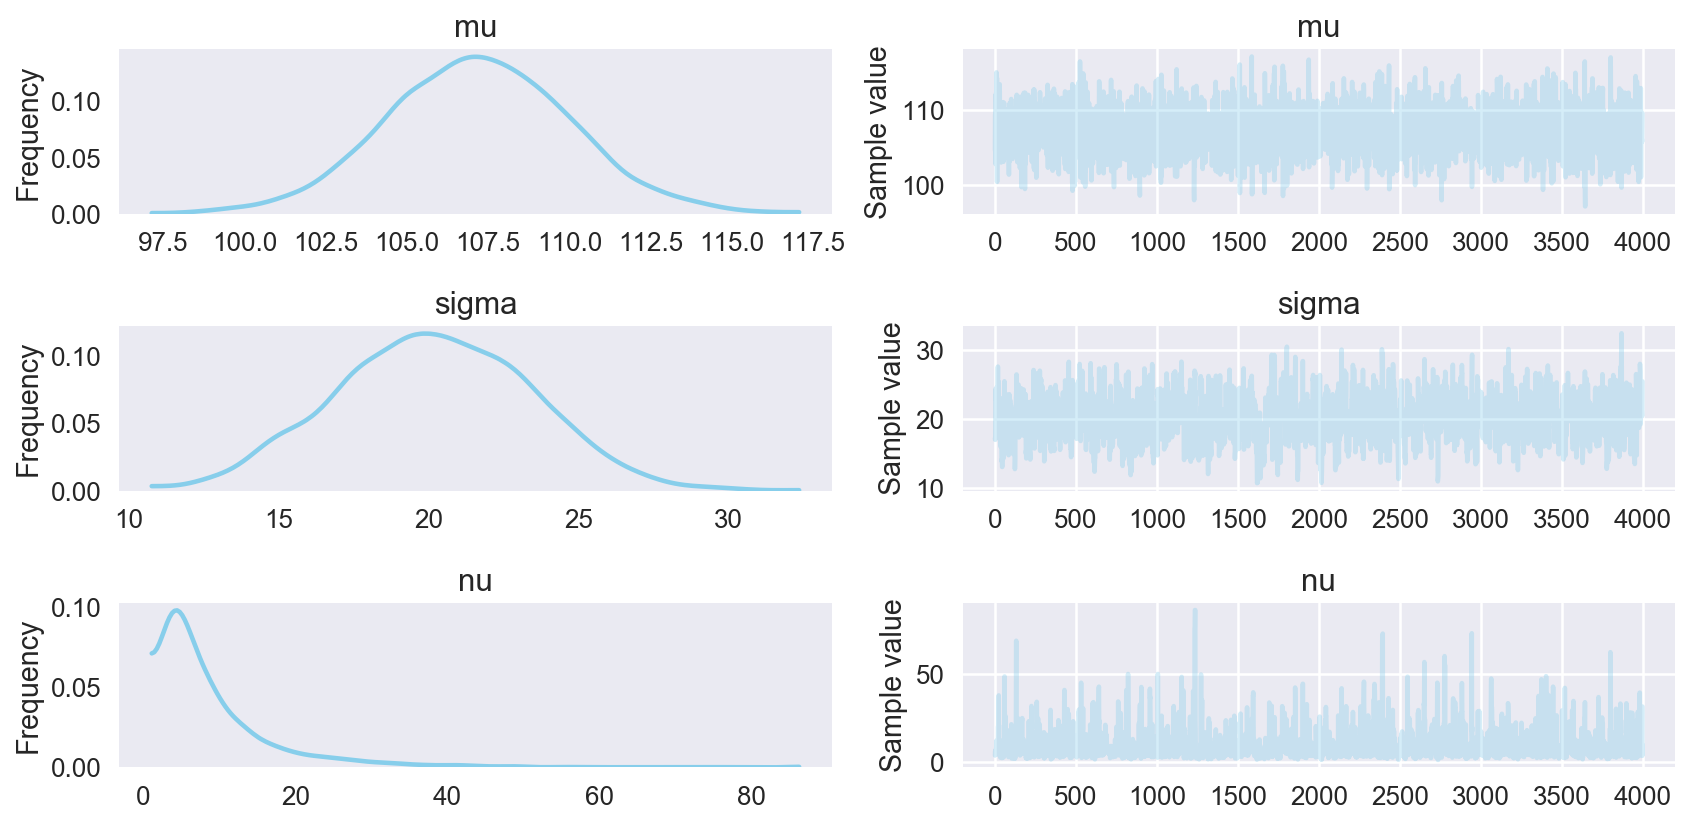

In [7]:
print pm.df_summary(trace)
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1179ff9d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11a660410>], dtype=object)

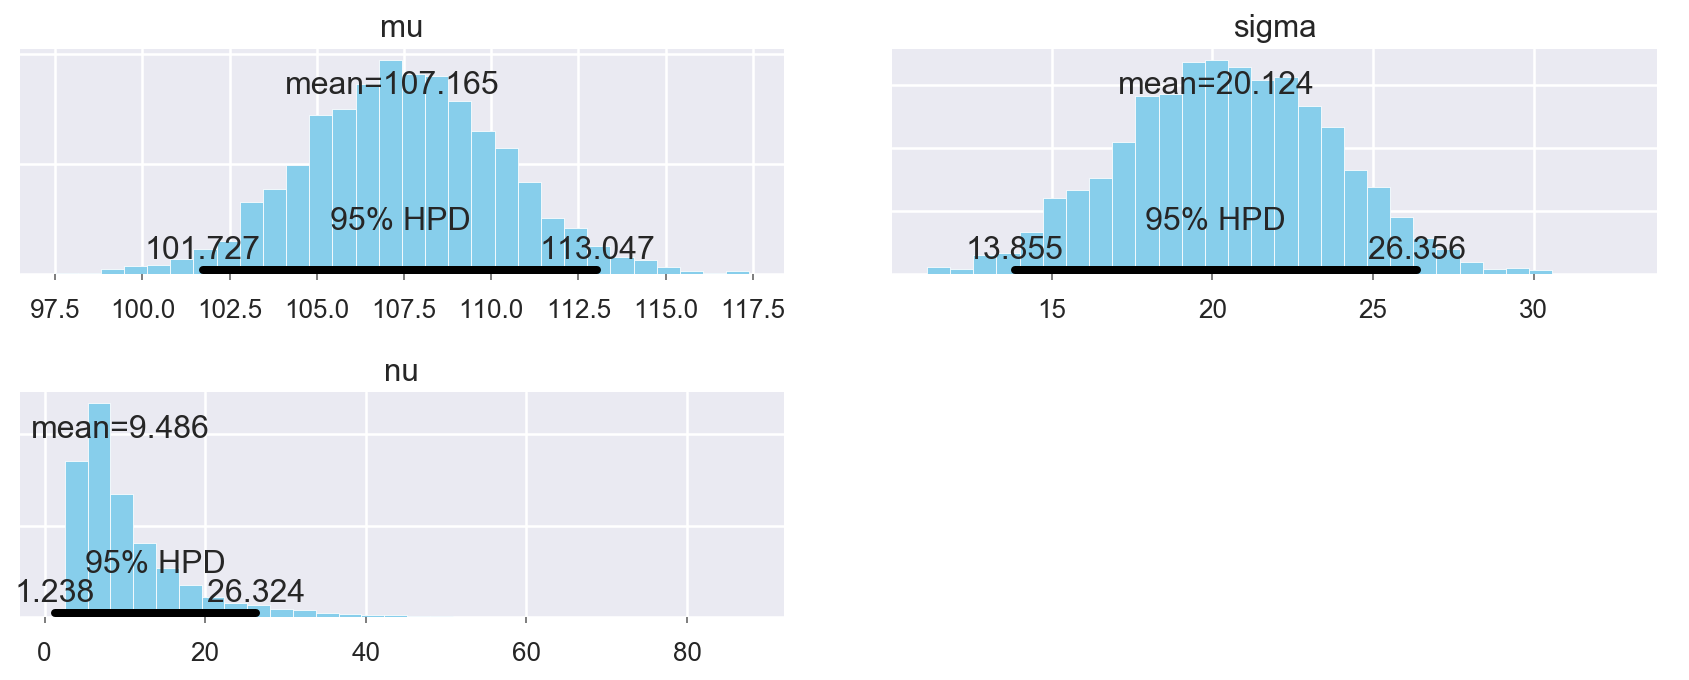

In [8]:
pm.plot_posterior(trace)